In [ ]:
#| default_exp linear_regression_rewrite

# Linear regression problem (rewrite)

We need:
- data preparation
-- generate some x,y data that we want to fit the linear model to
-- create datasets, data loaders
- model configuration
-- here we define model, loss, and optimizer
- write a class StepByStep
- train
- predict
- save model
- load model
- use tensorboard to see losses

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from torchviz import make_dot
plt.style.use('fivethirtyeight')

# generate some x,y data

we'll use numpy for this, and also need to split the data, can also use numpy for this

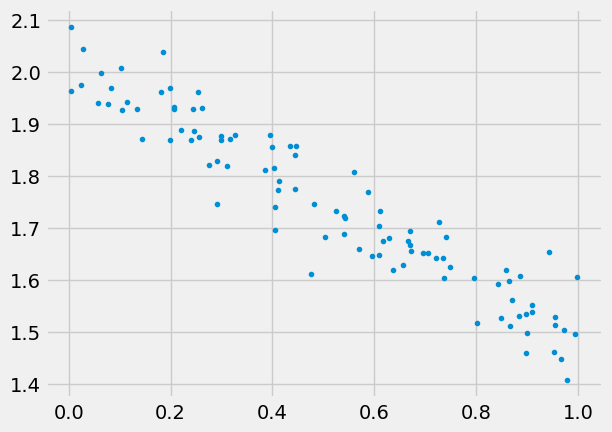

In [ ]:
np.random.seed(43)

b_true = 2.
w_true = -0.5
N = 100

x = np.random.rand(N,1)
epsilon = 0.05 * np.random.randn(N,1)
y = w_true*x + b_true + epsilon

plt.plot(x,y,'.')
plt.show()

# create datasets, data loaders

- data set is the object that holds features and labels together, 
- split the data into train and valid 
- convert to pytorch tensors
- create datasets
- create data_loaders

In [ ]:
np.random.seed(43)
indices = np.arange(N)
np.random.shuffle(indices)
train_indices = indices[:int(0.8*N)]
val_indices = indices[int(0.8*N):]

device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_x = torch.tensor(x[train_indices], dtype=torch.float32, device=device)
train_y = torch.tensor(y[train_indices], dtype=torch.float32, device=device)
val_x = torch.tensor(x[val_indices], dtype=torch.float32, device=device)
val_y = torch.tensor(y[val_indices], dtype=torch.float32, device=device)

train_dataset = TensorDataset(train_x, train_y)
val_dataset = TensorDataset(val_x, val_y)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# model, loss, and optimizer

In [ ]:
torch.random.manual_seed(42)
model = torch.nn.Linear(1,1, bias=True, device=device)
optimizer = optim.Adam(model.parameters(), lr=0.1)
loss_fn = nn.MSELoss()

# write a class StepByStep

In [ ]:
class StepByStep(object):
    def __init__(self, model, optimizer, loss_fn):
        self.model = model
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        
        self.model.to(self.device)
        
        self.train_loader = None
        self.val_loader = None
        
        self.total_epochs = 0
        
        self.losses = []
        self.val_losses = []
        
    def __str__(self):
        return f"{self.model}, {self.optimizer}, {self.loss_fn}"
        
    __repr__ = __str__ 
    
    def set_seed(self, seed=42):
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False    
        torch.manual_seed(seed)
        np.random.seed(seed)
        
    def set_loaders(self, train_loader, val_loader):
        self.train_loader = train_loader
        self.val_loader = val_loader
        
    def perform_train_step(self, batch_x, batch_y):
        self.model.train()
         
        predictions = self.model(batch_x)
        loss = self.loss_fn(predictions, batch_y)
        loss.backward()

        self.optimizer.step()
        self.optimizer.zero_grad()

        return loss.item()
    
    def perform_val_step(self, batch_x, batch_y):
        self.model.eval()
        
        predictions = self.model(batch_x)
        loss = self.loss_fn(predictions, batch_y)
        
        return loss.item()
        
    def train(self, n_epochs):
        
        self.set_seed()
        
        for epoch in range(n_epochs):
            self.total_epochs += 1
            train_losses = []
            for batch_x, batch_y in self.train_loader:
                train_losses.append(self.perform_train_step(batch_x, batch_y))
            self.losses.append(np.mean(train_losses))
            
            with torch.no_grad():
                val_losses = []
                for batch_x, batch_y in self.val_loader:
                    val_losses.append(self.perform_val_step(batch_x, batch_y))
                self.val_losses.append(np.mean(val_losses))
               
    def predict(self, x):
        self.model.eval()
        # need to evaluate
        prediction = self.model(torch.tensor(x).float())
        self.model.train()
        return prediction.detach().numpy()
        
    def plot_losses(self):
        fig = plt.figure(figsize=(10, 4))
        plt.plot(self.losses, label='Training loss', c='b')
        plt.plot(self.val_losses, label='Validation loss', c='r')
        plt.yscale('log')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
        
    def save_checkpoint(self, filename):
        checkpoint = {
            'epoch': self.total_epochs,
            'model': self.model.state_dict(),
            'optimizer': self.optimizer.state_dict(),
            'losses': self.losses,
            'val_losses': self.val_losses,
            }
        
        torch.save(checkpoint, filename)
        
    def load_checkpoint(self, filename):
        pass

# train

In [ ]:
model.reset_parameters()
sbs = StepByStep(model, optimizer, loss_fn)
sbs.set_loaders(train_loader, val_loader)
sbs.train(30)

In [ ]:
sbs.model.state_dict()

OrderedDict([('weight', tensor([[-0.5267]])), ('bias', tensor([2.0177]))])

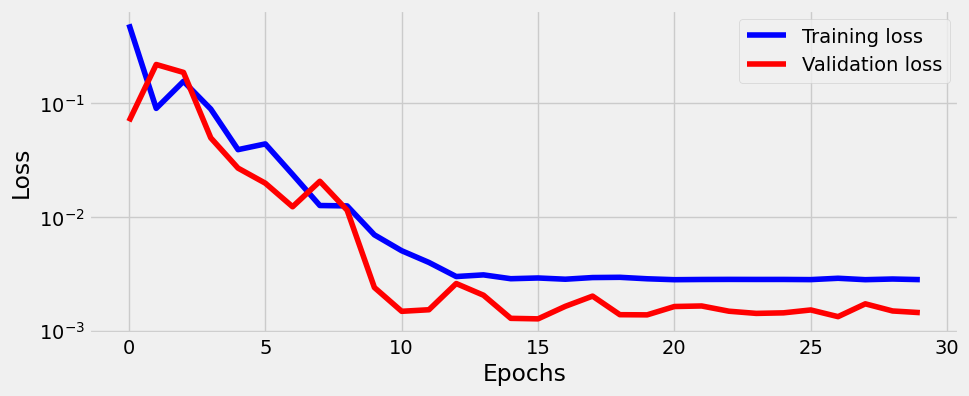

In [ ]:
sbs.plot_losses()

# predict

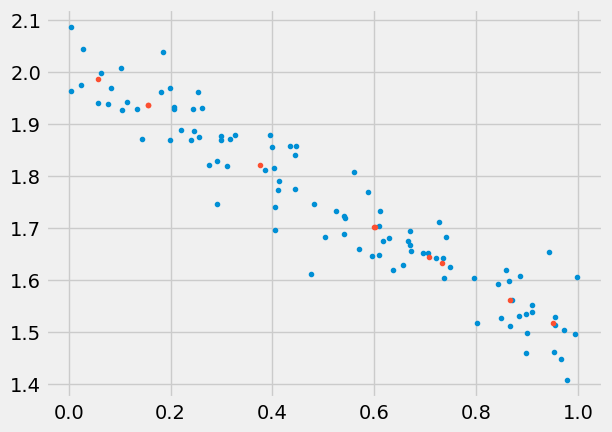

In [ ]:
test = np.random.rand(10,1)
test_predictions = sbs.predict(test)
plt.plot(x,y,'.')
plt.plot(test,test_predictions,'.')
plt.show()

# save model

In [ ]:
sbs.save_checkpoint('pera')

- load model
- use tensorboard to see losses

# Visualize model

In [ ]:
sbs

Linear(in_features=1, out_features=1, bias=True), Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.1
    maximize: False
    weight_decay: 0
), MSELoss()

In [ ]:
yhat = sbs.model(torch.rand(10,1))

In [ ]:
#| hide
# TODO can't run `make_dot(yhat)`  TODO make graphviz work on GitHub getting error ExecutableNotFound: failed to execute Path('dot'), make sure the
# Graphviz executables are on your systems' PATH